In [1]:
pip install git+https://github.com/illuin-tech/colpali


  Cloning https://github.com/illuin-tech/colpali to /tmp/pip-req-build-p2wf7ryt
  Running command git clone --filter=blob:none --quiet https://github.com/illuin-tech/colpali /tmp/pip-req-build-p2wf7ryt
  Resolved https://github.com/illuin-tech/colpali to commit 97e389a5ca83becbac51eee2dc5cb9967adc8b5e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   

In [6]:
import torch
from PIL import Image
from transformers.utils.import_utils import is_flash_attn_2_available
import os # Import the 'os' module to interact with the file system
from colpali_engine.models import ColQwen2, ColQwen2Processor

# --- 1. Model Loading (no changes here) ---
model_name = "vidore/colqwen2-v1.0"

print("Loading model and processor...")
model = ColQwen2.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",
    attn_implementation="flash_attention_2" if is_flash_attn_2_available() else "sdpa",
).eval()

processor = ColQwen2Processor.from_pretrained(model_name)
print("Model loaded successfully.")


# --- 2. Load Images from a Folder Path (This is the new part) ---
image_folder_path = "/content/images"
image_files = []
# Define common image file extensions
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}

print(f"\nLoading images from folder: '{image_folder_path}'")
# Check if the directory exists
if not os.path.isdir(image_folder_path):
    raise FileNotFoundError(f"The directory '{image_folder_path}' was not found. Please create it and add images.")

for filename in os.listdir(image_folder_path):
    # Check if the file has a valid image extension
    if any(filename.lower().endswith(ext) for ext in valid_extensions):
        image_files.append(os.path.join(image_folder_path, filename))

if not image_files:
    raise FileNotFoundError(f"No valid images found in '{image_folder_path}'.")

# Open each image file using Pillow
images = [Image.open(filepath).convert("RGB") for filepath in image_files]
print(f"Successfully loaded {len(images)} images.")


# --- 3. Define Queries (no changes here) ---
queries = [
    "A picture of a city skyline at night.",
    "A close-up of a red flower.",
    "A team of people working in an office.",
    "What is the organizational structure for our R&D department?",
    "Can you provide a breakdown of last year’s financial performance?",
]


# --- 4. Process Inputs and Get Embeddings (no changes here) ---
print("\nProcessing images and queries to generate embeddings...")
batch_images = processor.process_images(images).to(model.device)
batch_queries = processor.process_queries(queries).to(model.device)

# Forward pass
with torch.no_grad():
    image_embeddings = model(**batch_images) # Using embed_documents for clarity
    query_embeddings = model(**batch_queries) # Using embed_queries for clarity
print("Embeddings generated.")


# --- 5. Calculate and Display Scores ---
print("Calculating similarity scores...")
scores = processor.score_multi_vector(query_embeddings, image_embeddings)

print("\n--- Similarity Score Matrix ---")
# The shape will be (number_of_queries, number_of_images)
print(f"Matrix Shape: {scores.shape}")
print(scores)

# Optional: Print a more readable version of the results
print("\n--- Top Image for Each Query ---")
# Find the index of the image with the highest score for each query
top_image_indices = torch.argmax(scores, dim=1)

for i, query in enumerate(queries):
    top_image_index = top_image_indices[i].item()
    top_image_path = image_files[top_image_index]
    top_score = scores[i][top_image_index].item()
    print(f"Query: \"{query}\"")
    print(f"  -> Best Match: {os.path.basename(top_image_path)} (Score: {top_score:.4f})")

Loading model and processor...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully.

Loading images from folder: '/content/images'
Successfully loaded 4 images.

Processing images and queries to generate embeddings...
Embeddings generated.
Calculating similarity scores...

--- Similarity Score Matrix ---
Matrix Shape: torch.Size([5, 4])
tensor([[ 8.2500, 12.6875, 11.2500,  8.6250],
        [ 9.1250,  8.0000,  7.9062,  8.0000],
        [ 7.7812,  7.1562,  7.2188,  8.1875],
        [ 7.8438,  7.5938,  8.8750,  7.7812],
        [ 7.4375,  8.5625,  7.5625,  7.0312]])

--- Top Image for Each Query ---
Query: "A picture of a city skyline at night."
  -> Best Match: art4_shore.jpg (Score: 12.6875)
Query: "A close-up of a red flower."
  -> Best Match: art1_peacock.jpg (Score: 9.1250)
Query: "A team of people working in an office."
  -> Best Match: art2_musicians.jpg (Score: 8.1875)
Query: "What is the organizational structure for our R&D department?"
  -> Best Match: art3_shore.jpg (Score: 8.8750)
Query: "Can you provide a breakdown of last year’s f

Please upload your images to the '/content/images' directory.


Saving art4_shore.jpg to art4_shore (1).jpg
Saving art3_shore.jpg to art3_shore (1).jpg
Saving art2_musicians.jpg to art2_musicians (1).jpg
Saving art1_peacock.jpg to art1_peacock (1).jpg



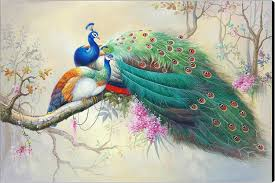
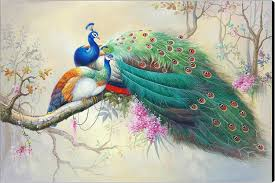
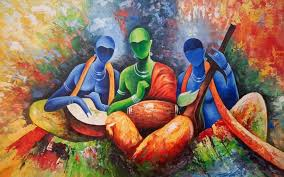
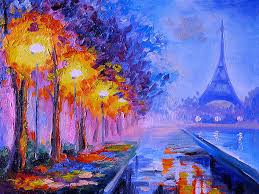
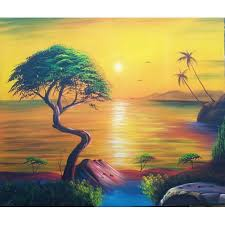
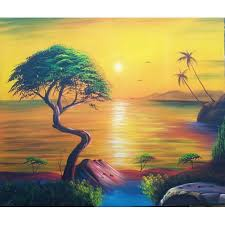
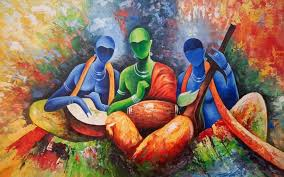
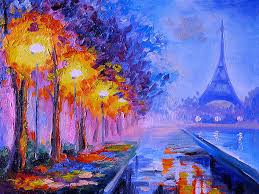

In [7]:
import os
from google.colab import files
from IPython.display import HTML, display
import base64
from io import BytesIO
from PIL import Image

# --- 1. Create a folder and prompt for upload ---
folder_path = '/content/images'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

print(f"Please upload your images to the '{folder_path}' directory.")
# Change directory into the folder to make uploads go there directly
os.chdir(folder_path)
# Open the file upload dialog
uploaded = files.upload()
# Change back to the main content directory
os.chdir('/content/')

# --- 2. Find all uploaded images ---
image_paths = []
valid_extensions = {".jpg", ".jpeg", ".png", ".gif", ".bmp"}
for filename in os.listdir(folder_path):
    if any(filename.lower().endswith(ext) for ext in valid_extensions):
        image_paths.append(os.path.join(folder_path, filename))

# --- 3. Generate and display the HTML ---
if not image_paths:
    print("No images found. Please upload some images and run the cell again.")
else:
    # Define the JavaScript function for copying to clipboard
    javascript = """
    <script>
      function copyPath(path, button) {
        navigator.clipboard.writeText(path).then(function() {
          const originalText = button.innerText;
          button.innerText = 'Copied!';
          setTimeout(() => { button.innerText = originalText; }, 2000);
        }, function(err) {
          console.error('Could not copy text: ', err);
          alert('Failed to copy path.');
        });
      }
    </script>
    """

    # Start building the HTML string
    html_content = javascript + "<div>"

    # Style for the container divs
    div_style = "border: 1px solid #ddd; border-radius: 8px; padding: 10px; margin: 10px; display: inline-block; text-align: center; box-shadow: 2px 2px 5px rgba(0,0,0,0.1);"
    img_style = "max-width: 200px; max-height: 200px; border-radius: 4px;"
    button_style = "margin-top: 10px; padding: 8px 12px; cursor: pointer; border: 1px solid #ccc; border-radius: 4px; background-color: #f0f0f0;"

    for path in image_paths:
        try:
            # Open the image and convert to Base64
            img = Image.open(path)
            buffer = BytesIO()
            img.save(buffer, format='PNG')
            img_str = base64.b64encode(buffer.getvalue()).decode()

            # Create the HTML for one image item
            html_content += f"""
            <div style='{div_style}'>
              <img src='data:image/png;base64,{img_str}' style='{img_style}' alt='{os.path.basename(path)}' />
              <p style='font-family: monospace; font-size: 12px; margin-top: 8px; word-wrap: break-word;'>{path}</p>
              <button style='{button_style}' onclick="copyPath('{path}', this)">Copy Path</button>
            </div>
            """
        except Exception as e:
            print(f"Could not process file {path}: {e}")

    html_content += "</div>"

    # Display the final HTML
    display(HTML(html_content))

In [1]:
!huggingface-cli login --token

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `Flipkart` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `Flipkart`


In [12]:
pip install git+https://github.com/huggingface/diffusers.git

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-0g259q3t
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-0g259q3t
  Resolved https://github.com/huggingface/diffusers.git to commit 377057126c75221493b51b991b1b3ae8c5421562
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.35.0.dev0-py3-none-any.whl size=4077489 sha256=2a5603978af8f5c6b83937f0f3b1ea32d24af8d1878902bb20334d21f66f6d85
  Stored in directory: /tmp/pip-ephem-wheel-cache-prbcwq0a/wheels/d2/5c/5f/16639722ea17ecb73ab461b81718584bac08af2801619786b9
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.34.0
    Uninstalling diffusers-0.34.0:
      Successfully uninstalled diffusers-0.34.0


In [ ]:
import torch
from diffusers import FluxKontextPipeline
from diffusers.utils import load_image

pipe = FluxKontextPipeline.from_pretrained("black-forest-labs/FLUX.1-Kontext-dev", torch_dtype=torch.bfloat16)
pipe.to("cuda")


prompt = "Make it modern"
input_image = load_image("/content/images/art4_shore (1).jpg")

image = pipe(image=input_image, prompt=prompt).images[0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

text_encoder_2/model-00002-of-00002.safe(…):   0%|          | 0.00/4.53G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/561 [00:00<?, ?B/s]

text_encoder_2/model-00001-of-00002.safe(…):   0%|          | 0.00/4.99G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.98G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.95G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/3.87G [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

In [3]:
from diffusers import DiffusionPipeline
from diffusers.utils import load_image

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting")

prompt = "add more colors"
input_image ="/content/images/art1_peacock.jpg"

image = pipe(image=input_image, prompt=prompt).images[0]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

ValueError: Input is in incorrect format. Currently, we only support <class 'PIL.Image.Image'>, <class 'numpy.ndarray'>, <class 'torch.Tensor'>

ADD MORE DETAILS TO IMAGE

In [4]:
from diffusers import DiffusionPipeline
from diffusers.utils import load_image
from PIL import Image

# Load pipeline
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting")
pipe = pipe.to("cuda")  # Optional: move to GPU if available

# Load input image
input_image = load_image("/content/images/art1_peacock.jpg")

# Create or load a mask image (white = inpaint area, black = keep as is)
# For demonstration, here's a dummy mask (full white = inpaint all)
mask_image = Image.new("RGB", input_image.size, (255, 255, 255))

# Run inpainting
result = pipe(
    prompt="add more colors",
    image=input_image,
    mask_image=mask_image
).images[0]

# Save or display the result
result.save("/content/inpainted_peacock.jpg")
result.show()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]